In [1]:
import torch
import torch.optim as optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from image_transform_net import ImageTransformerNet
from loss_network import LossNetwork
import utils
import numpy as np
import time

%load_ext autoreload

%autoreload 2

In [2]:
device = torch.device("cuda")

In [3]:
np.random.seed(0)
torch.manual_seed(0)

In [4]:
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])

batch_size = 4
train_dataset = datasets.ImageFolder("../coco/", transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [5]:
len(train_loader)

10126

In [6]:
transformer = ImageTransformerNet().to(device)
optimizer = optim.Adam(transformer.parameters(), lr=1e-3)
mse_loss = torch.nn.MSELoss()

(-0.5, 399.5, 399.5, -0.5)

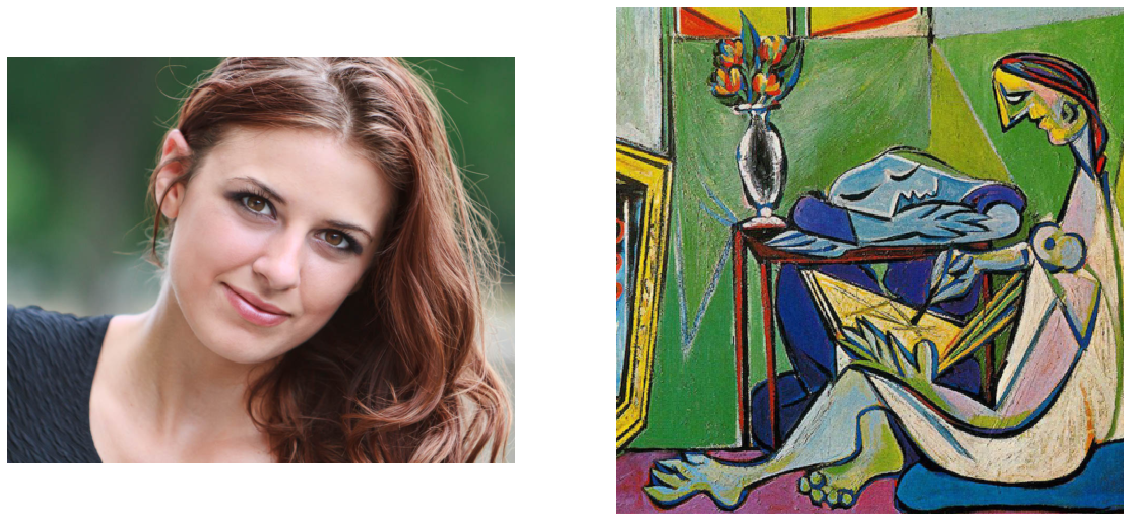

In [7]:
style = utils.load_image("../images/style/la_muse.jpg", size=400).to(device)
content = utils.load_image('../images/content/p8.jpg', size=400).to(device)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(utils.im_convert(content))
ax1.axis("off")
ax2.imshow(utils.im_convert(style))
ax2.axis("off")



(-0.5, 503.5, 403.5, -0.5)

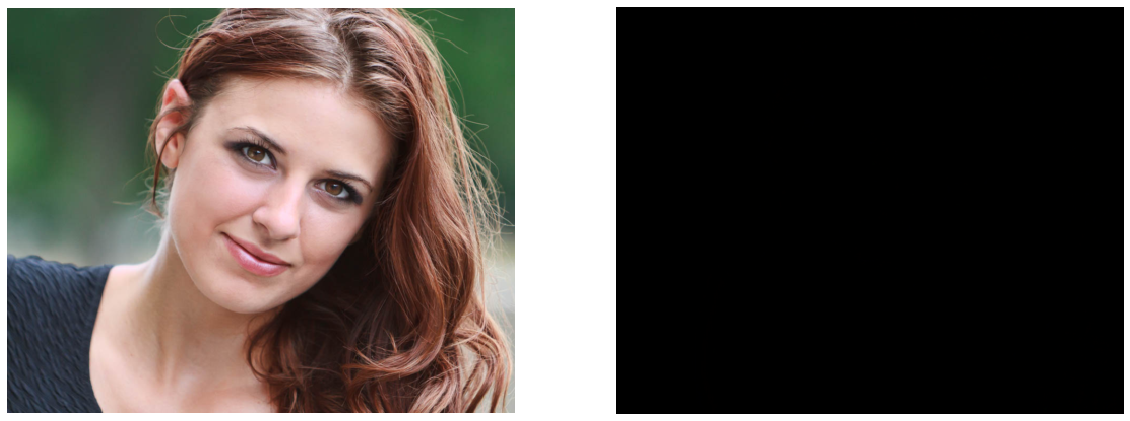

In [8]:
styled = transformer(content)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(utils.im_convert(content))
ax1.axis("off")
ax2.imshow(utils.im_convert(styled))
ax2.axis("off")


In [9]:
style = style.repeat(batch_size, 1, 1, 1).to(device)

In [10]:
loss_network = LossNetwork(requires_grad=False).to(device)
features_style = loss_network(utils.normalize_batch(style))

In [11]:
# for key in features_style:
#     gram_style[key] = torch.stack([utils.gram_matrix(features_style[key][i]) for i in range(batch_size)], dim=0)

gram_style = [utils.gram_matrix(y) for y in features_style]

In [ ]:
epochs = 5
content_weight = 1e5
style_weight = 1e11
log_interval = 100
draw_image_interval = 800
for epoch in range(epochs):
    transformer.train()
    agg_content_loss = 0.
    agg_style_loss = 0.
    count = 0
    for batch_id, (x, _) in enumerate(train_loader):
        n_batch = len(x)
        count += n_batch
        optimizer.zero_grad()
        
        x_origin = x.clone().detach()
        
        x = x.to(device)
        y = transformer(x)
        
        y = utils.normalize_batch(y)
        x = utils.normalize_batch(x)
        
        features_y = loss_network(y)
        features_x = loss_network(x)
        
        content_loss = content_weight * mse_loss(features_x.relu2_2, features_y.relu2_2)
        
        style_loss = 0.
        for ft_y, gm_s in zip(features_y, gram_style):
            gm_y = utils.gram_matrix(ft_y)
            style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
        style_loss *= style_weight
        
        total_loss = style_loss + content_loss
        total_loss.backward()
        optimizer.step()
        
        agg_content_loss += content_loss.item()
        agg_style_loss += style_loss.item()
        
        if (batch_id + 1) % log_interval == 0:
            mesg = "{} - Epoch {}: [{}/{}] - content: {:.3f} - style: {:.3f} - total: {:.3f}".format(
                time.ctime(), epoch + 1, count, len(train_dataset),
                              agg_content_loss / (batch_id + 1),
                              agg_style_loss / (batch_id + 1),
                              (agg_content_loss + agg_style_loss) / (batch_id + 1)
            )
            print(mesg)
            
        if (batch_id + 1) % draw_image_interval == 0:
            styled = transformer(x_origin.to(device))
            fig, axs = plt.subplots(2, batch_size, figsize=(16, 6))
            for i in range(batch_size):
                axs[0][i].imshow(utils.im_convert(x_origin[i]))
                axs[0][i].axis("off")
                axs[1][i].imshow(utils.im_convert(styled[i]))
                axs[1][i].axis("off")
            plt.show()


    
        

In [14]:
# save model
save_model_dir = "models"
transformer.eval().cpu()
save_model_filename = "epoch_" + str(epochs) + "_" + str(time.ctime()).replace(' ', '_') + "_" + str(content_weight) + "_" + str(style_weight) + ".model"
save_model_path = os.path.join(save_model_dir, save_model_filename)
torch.save(transformer.state_dict(), save_model_path)


NameError: name 'os' is not defined